# Config R-CNN 

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import glob

# Root directory of the project
ROOT_DIR = os.path.abspath("Mask_RCNN-master/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize


# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush', 'BG_object_close']

## Run Object Detection Example

Processing 1 images
image                    shape: (425, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



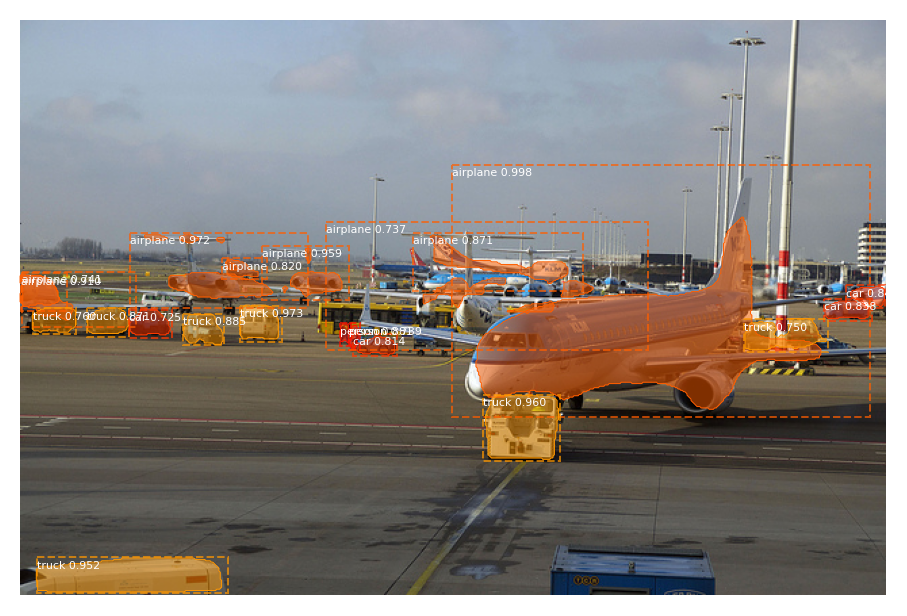

In [5]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [6]:
img = visualize.return_image(image, 'test', r['rois'], r['masks'], r['class_ids'],r['scores'], class_names)

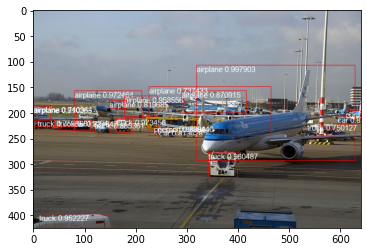

In [7]:
plt.imshow(img)

# Run DHF1K

In [9]:
video_nr = 2

DHF1K_DATA_PATH = f"/Users/timschroder/Documents/Uni/Bachelorarbeit/Color_Segmentation/Code/Data/{video_nr:003}/*.png"
SAVE_IMAGE_PATH = f"/Users/timschroder/Documents/Uni/Bachelorarbeit/project_code/graphics/detect_img/{video_nr:003}/"
filenames = [img for img in glob.glob(DHF1K_DATA_PATH)]
filenames.sort()
total_frames = 2 #len(filenames)

In [10]:
filename_list = filenames[:total_frames].copy() #cut frame_list
detect_img = []
img = []
for image in filename_list:   #BATCH_SIZE = 1
    curr_img = (skimage.io.imread(image))
    img.append(curr_img)
    results = model.detect([curr_img], verbose=1)
    r = results[0]
    visualize.display_instances(curr_img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [12]:
image.type

AttributeError: 'numpy.ndarray' object has no attribute 'type'

/Users/timschroder/Documents/Uni/Bachelorarbeit/project_data/DHF1K_25
/Users/timschroder/Documents/Uni/Bachelorarbeit/project_data/DHF1K_25/002.AVI
Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



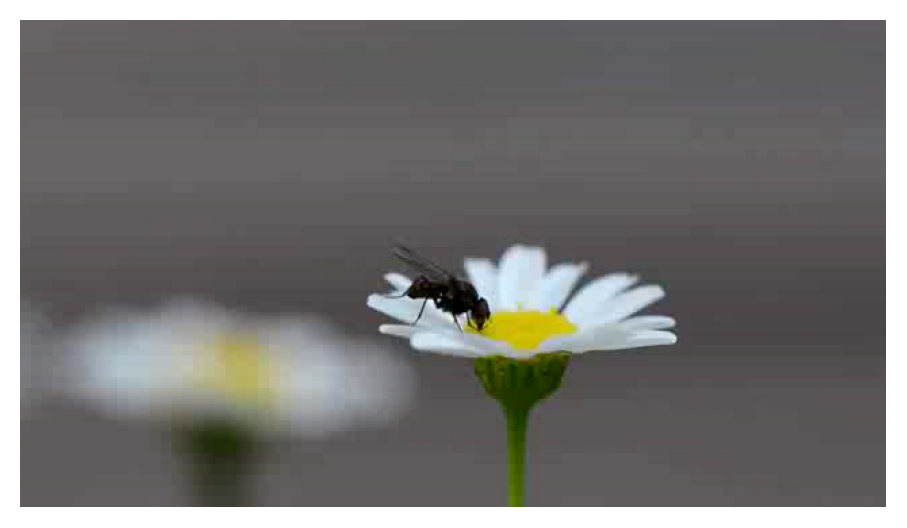

Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



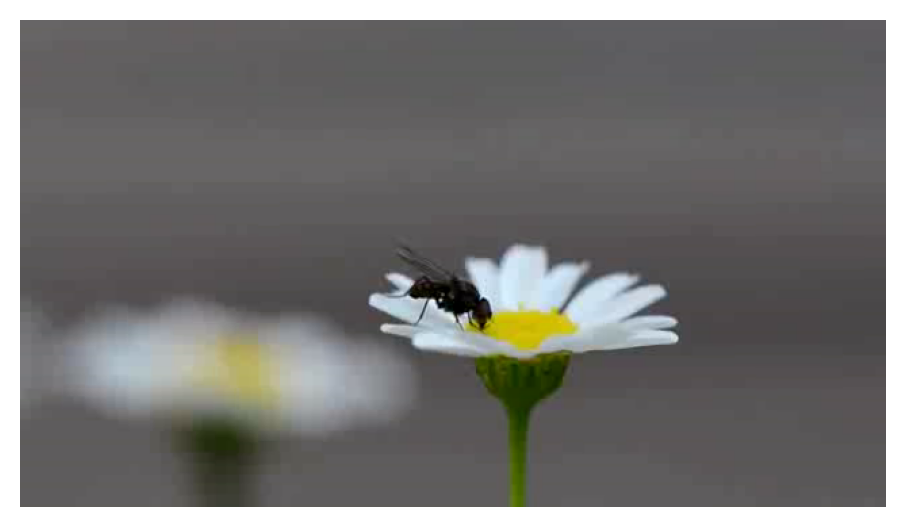

Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



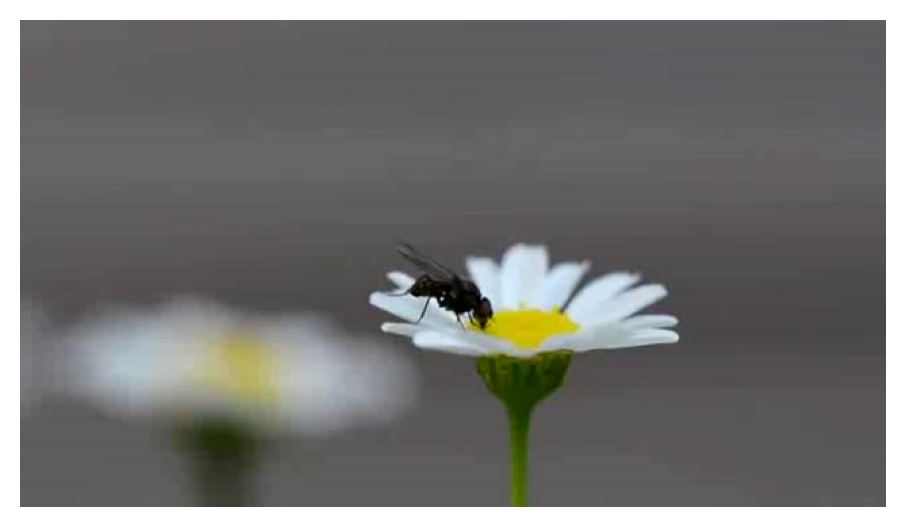

Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



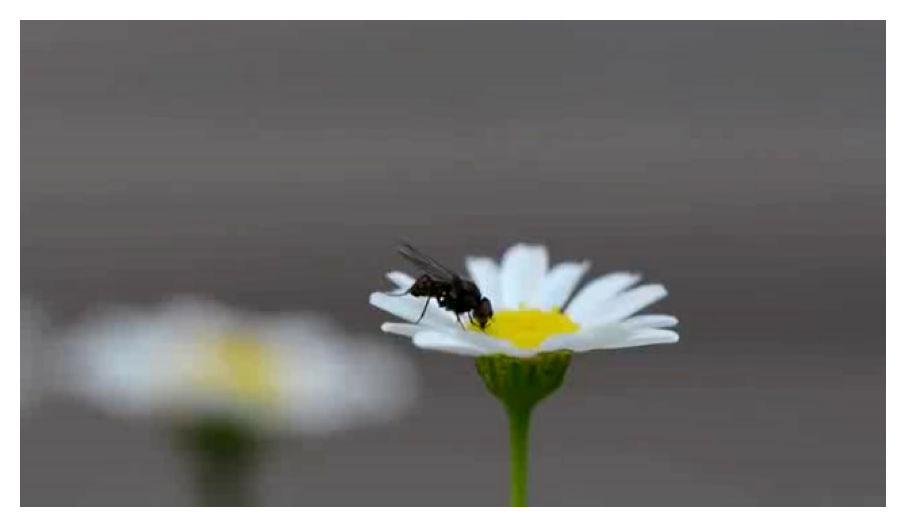

Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



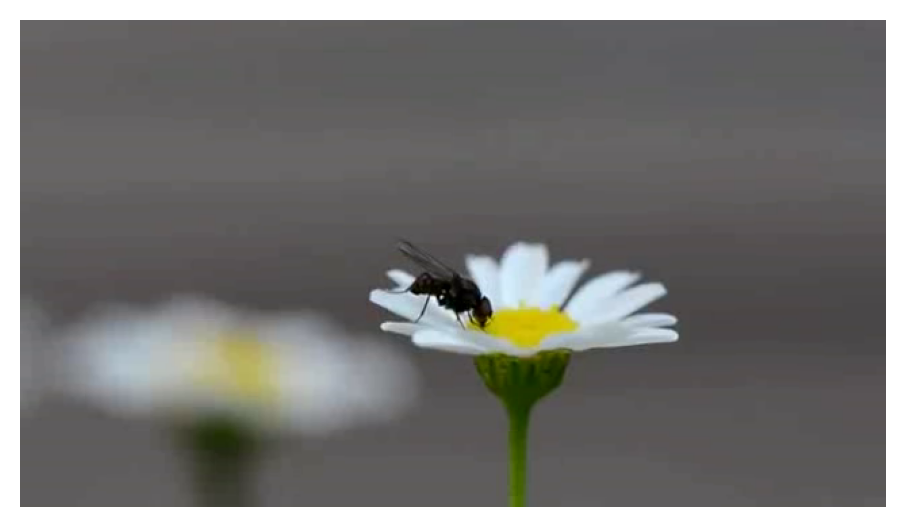

Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



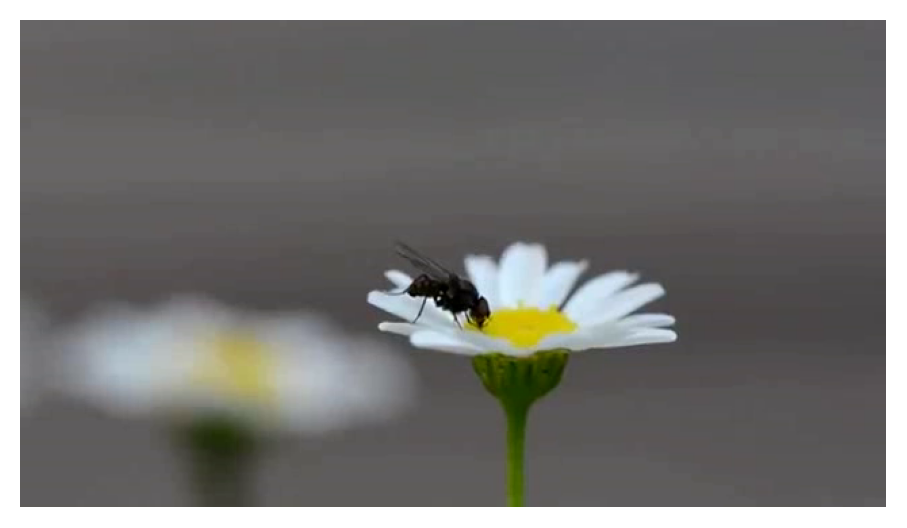

Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



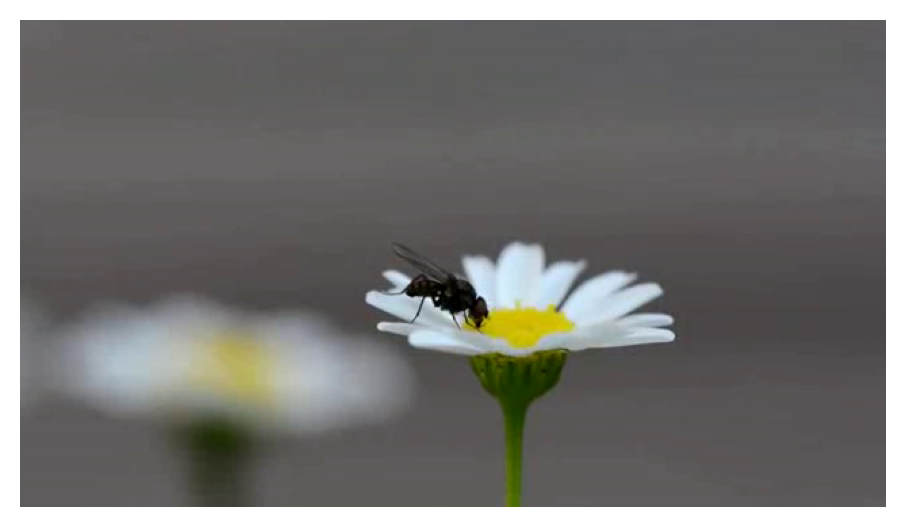

Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


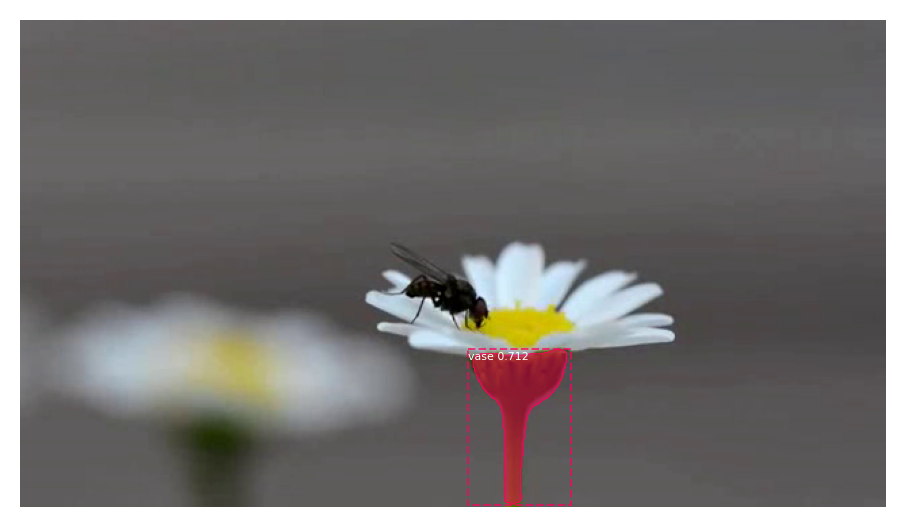

Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


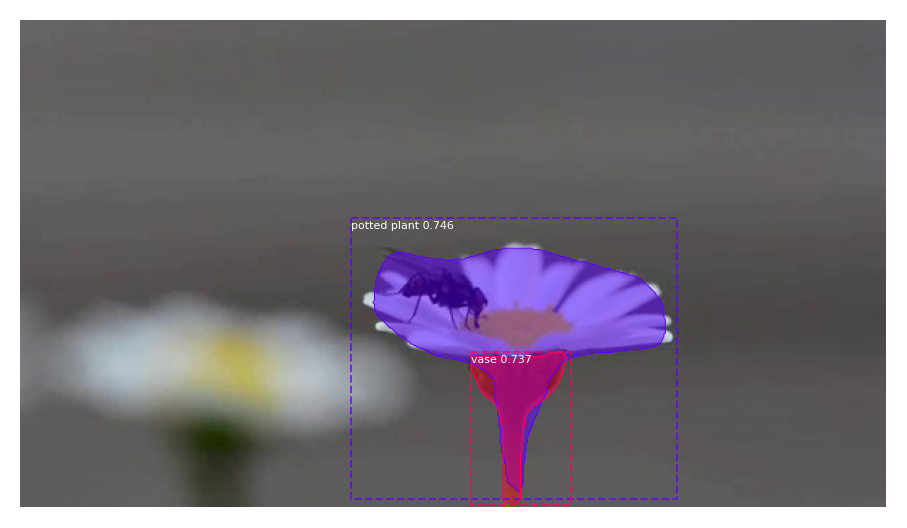

Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


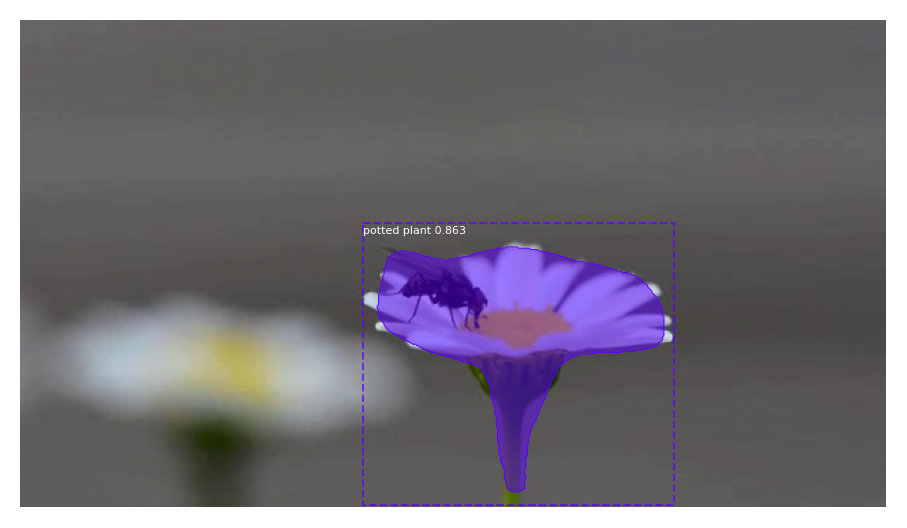

Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


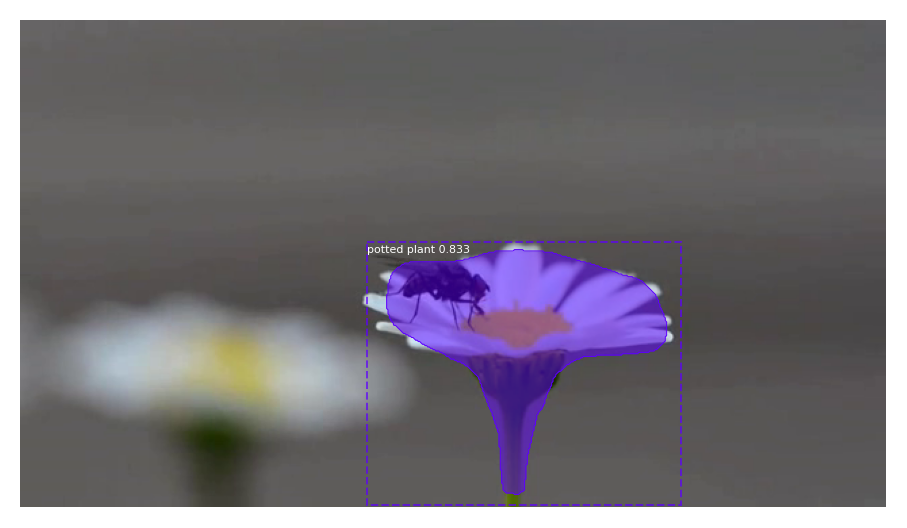

Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


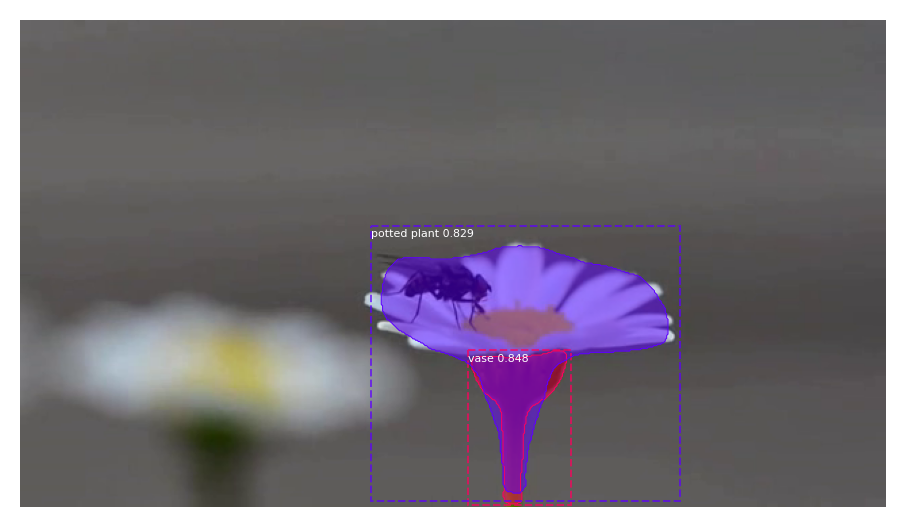

Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


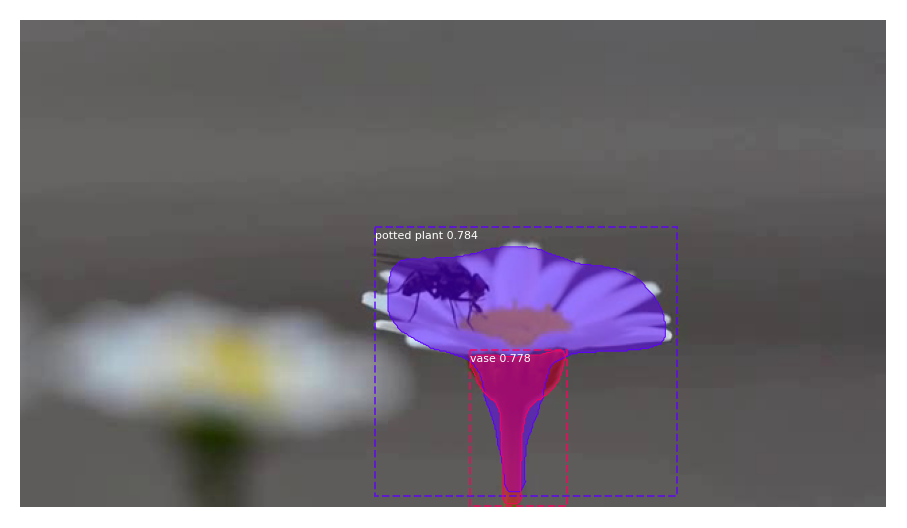

In [11]:
import imageio
import os
from pathlib import Path

CODE_DIR = Path(os.path.dirname(os.path.realpath('__file__')))
DATA_DIR = os.path.join(CODE_DIR.parent, 'project_data')

videos_run = [1]
VIDEO_PATH = os.path.join(DATA_DIR, 'DHF1K_25')
detect_img = []
print(VIDEO_PATH)

#for v in videos_run:
v=2
videoloc = os.path.join(VIDEO_PATH, f'{v:03}.AVI')
print(videoloc)
vid = imageio.get_reader(videoloc,  'ffmpeg')
count = 0
for image in vid.iter_data():
    if count < 13:
        count = count +1
        results = model.detect([image], verbose=1)
        detect_img.append(results[0])
        r = results[0]
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
    else:
        break

In [16]:
detect_img[1]

{'rois': array([[ 73, 241, 189, 318],
        [ 85, 298, 227, 386],
        [191, 294, 338, 384],
        [155,  17, 257,  68],
        [173, 410, 279, 482],
        [ 84, 211, 150, 259],
        [ 15, 606,  95, 640],
        [244, 551, 359, 640],
        [160, 455, 229, 544],
        [ 28, 393, 104, 422],
        [ 29, 496,  72, 508],
        [ 72, 325, 127, 355],
        [ 99,  95, 175, 159],
        [  8, 199,  35, 211],
        [125, 599, 253, 640],
        [  0, 228,  37, 245],
        [141, 217, 197, 255],
        [184, 154, 280, 197],
        [ 66, 122,  89, 144],
        [209,   0, 328,  47],
        [170, 272, 197, 293],
        [ 40, 412, 126, 497],
        [ 29, 515,  55, 531],
        [257, 369, 360, 485],
        [  7, 301,  59, 327],
        [ 61,  45,  76,  58],
        [116, 429, 203, 466],
        [ 29, 444,  51, 470],
        [ 33, 335,  78, 362],
        [ 32, 361, 103, 408],
        [128, 123, 215, 167],
        [122,  45, 188,  93],
        [ 29, 369,  56, 392],
  

### Save Images

In [62]:
%load_ext autoreload
%autoreload
import importlib
from mrcnn.visualize import save_image
importlib.reload(visualize)

for i in range(len(detect_img)):
    r = detect_img[i]
    save_image(SAVE_IMAGE_PATH,img[i],('%04d'%i),r['rois'], r['masks'], r['class_ids'], r['scores'], class_names)
    
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Total Mask

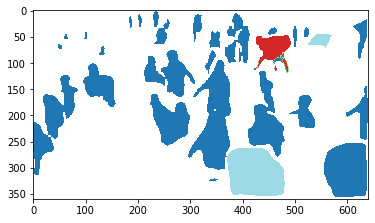

BG
person
bicycle
horse
sheep
chair


In [64]:
total_mask = []
for i in range(len(img)):
    r = detect_img[i]
    values = r.values()
    values_list = list(values)
    mask_list = np.moveaxis(values_list[3], 2, 0) # n frames with shape 360 , 640
    class_id_list = values_list[1]
    total_mask.append(sum(np.where(mask_list[i], class_id_list[i], 0) for i in range(0, len(mask_list))))


# ----Visualize Example------

masked_array = np.ma.masked_where(total_mask[0] == 0, total_mask[0])
cmap = matplotlib.cm.tab20  # Can be any colormap that you want after the cm
cmap.set_bad(color='white')

plt.imshow(masked_array, cmap=cmap)
plt.show()

for c in np.unique(total_mask[0]): # all class_names included in frame
    print(class_names[c])


In [322]:
import pickle
with open('total_mask.pickle', 'wb') as f:
    pickle.dump(total_mask, f)


In [329]:
dict_data = np.load('total_mask.npz')

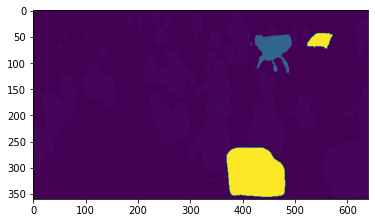

In [358]:
t = dict_data['arr_0']
plt.imshow(t[0])


TypeError: Invalid shape (1, 360, 640) for image data

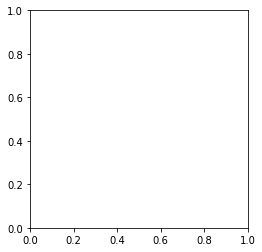

In [328]:
with open('total_mask.pickle') as f:
    test = pickle.load(f)

#print('total_mask is', total_mask[1])

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

## Read Eye-Tracking Data

 

/Users/timschroder/Documents/Uni/Bachelorarbeit/project_data/eye_tracking_data_tim/DHF1K_gaze/P01/P01_Trail001.txt


/Users/timschroder/env/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/timschroder/env/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


FIX        3128
NOISE       360
SP          236
SACCADE     125
Name: event_class, dtype: int64


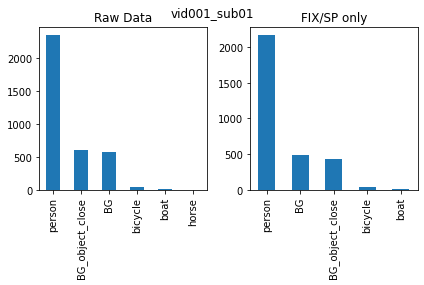

In [290]:
GAZEPATH = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_data/eye_tracking_data_tim/DHF1K_gaze/'
EVENTPATH = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_data/eye_tracking_data_tim/events_vid1-50_600-650/'
HIST_PATH = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_code/graphics/histplots/'
screen_res_x = 1440; screen_res_y = 900
video_res_x = 640;   video_res_y = 360

a=video_res_x/screen_res_x
# size of unused screen in y direction
b=(screen_res_y-video_res_y/a)/2
translate_dict = {'NOISE':0, 'FIX':1, 'SP':2, 'SACCADE':3}
for s in range(1,2):
    v = 1
    #s = 1

    filename = f'P{s:02}/P{s:02}_Trail{v:03}.txt'
    txtloc = GAZEPATH+filename
    print(txtloc)
    df = pd.read_csv(txtloc, sep='\t')
    df = df.drop(columns=['Type', 'Trial', 'L Dia X [px]', 'L Dia Y [px]'])
    df.columns = ['time', 'x', 'y', 'event_tracker']
    # set absolute timestamp (in micro seconds) relative to video start
    df['time']-=df['time'][0]

    eventlist = np.load(EVENTPATH + f'vid{v:03}_sub{s:02}_eventlist.npy', allow_pickle=True)
    # event_num is just for visualization
    #event_num = list(map(lambda x: translate_dict[x], eventlist))
    # classification added to dataframe for later filtering
    df['event_class'] = eventlist
    # scale x,y to video_res
    df['x'] = np.round(df['x']*a).astype(int)
    df['y'] = np.round((df['y']-b)*a).astype(int)
    # just use gaze that actually was on the video
    df = df[df['y'] >= 0]
    df = df[df['y'] < video_res_y]
    df = df[df['x'] >= 0]
    df = df[df['x'] < video_res_x]

    #reindex cause of missing rows
    df = df.reset_index()
    df = df.drop(columns=['index'])
    # Add class_ID 
    fps = 30
    df['class_id'] = np.nan
    for f in range(len(img)):
        dtemp = df[(df['time'] >= 1e6*f/fps) & (df['time'] < 1e6*(f+1)/fps)] # assign data to frames
        for i in dtemp.index:
            x_coord = dtemp['x'][i]
            y_coord = dtemp['y'][i]
            class_id = total_mask[f][y_coord, x_coord]
            if class_id == 0:
                size = 10
                mask = total_mask[f][y_coord-size:y_coord+size, x_coord-size:x_coord+size]
                if np.count_nonzero(mask) > 0:
                    class_id = 81
            df['class_id'][i] = class_names[class_id]
    #Only Fixation/SP
    dhist = df[(df['event_class']=='FIX') | (df['event_class']=='SP')]
    if dhist.empty:
        print('%i has no FIX/SP Data'%s)

    else:
        print(df['event_class'].value_counts())
        #Hist
        hist1 = df['class_id'].value_counts()
        hist2 = dhist['class_id'].value_counts()
        fig = plt.figure()
        plt.title(f'Raw Data - vid{v:03}_sub{s:02}')
        plt.subplot(1, 2, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
        hist1.plot(kind='bar', subplots=True) 
        plt.title('Raw Data')
        
        plt.subplot(1, 2, 2)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
        hist2.plot(kind='bar', subplots=True) 
        plt.title('FIX/SP only')
        fig.suptitle(f'vid{v:03}_sub{s:02}')
        plt.subplots_adjust(hspace = 0.5,wspace = 0.5)
        plt.tight_layout()
        #plt.savefig(HIST_PATH +f'vid{v:03}_sub{s:02}_hist.png')
        plt.show()


## Histogramm

In [253]:
size = 10
x_coord = 490
y_coord = 167
f=0
mask = total_mask[f][y_coord-size:y_coord+size, x_coord-size:x_coord+size]
if np.count_nonzero(mask) > 0:
    
    


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [287]:
df

,time,x,y,event_tracker,event_class,class_id
0,0,492,166,Saccade,NOISE,BG
1,3982,492,165,Saccade,NOISE,BG
2,7966,490,167,Saccade,NOISE,BG
3,11957,490,168,Saccade,NOISE,BG
4,15987,473,166,Saccade,NOISE,BG
...,...,...,...,...,...,...
3844,16157938,311,129,Fixation,FIX,NaN
3845,16161925,311,130,Fixation,FIX,NaN
3846,16165880,311,131,Fixation,FIX,NaN
3847,16169891,311,131,Fixation,FIX,NaN


## Plots

,time,x,y,event_tracker,class_id
0,0,492,166,Saccade,BG
1,3982,492,165,Saccade,BG
2,7966,490,167,Saccade,BG
3,11957,490,168,Saccade,BG
4,15987,473,166,Saccade,person
...,...,...,...,...,...
3577,14977999,320,134,Saccade,person
3578,14982008,314,133,Saccade,person
3579,14986030,307,136,Saccade,person
3580,14989975,307,137,Saccade,person


In [262]:
for i in dtemp.index:
    print(i)

826
828
829
830
831
832
833


## Animate

In [288]:
import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

GAZEPATH = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_data/eye_tracking_data_tim/DHF1K_gaze/'
VIDEOPATH = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_data/DHF1K_25/'
EVENTPATH = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_data/eye_tracking_data_tim/events_vid1-50_600-650/'
translate_dict = {'NOISE':0, 'FIX':1, 'SP':2, 'SACCADE':3}

screen_res_x = 1440; screen_res_y = 900
video_res_x = 640
video_res_y = 360
a=video_res_x/screen_res_x
# size of unused screen in y direction
b=(screen_res_y-video_res_y/a)/2
fps=30
fourcc = cv2.VideoWriter_fourcc(*'DIVX')

videos_run = [1]
subjects_run = [1] #[s+1 for s in range(17)]

markersize = 50
maxframes = 1000

SLIC = False
n_segments = 200
compactness = 10


for v in videos_run:
    videoloc = VIDEOPATH + f'{v:03}.AVI'
    vid = imageio.get_reader(videoloc,  'ffmpeg')
    vidlist = []
    for image in vid.iter_data():
        vidlist.append(np.array(image))
    for s in subjects_run:
        nframes = len(vidlist)
        scanpath = []
        video_name = f'new_eventVisual_vid{v:03}_sub{s:02}_{maxframes}frames.avi'
        if SLIC:
            video_name = 'slic_'+video_name
        print(video_name)
        # 10 fps, output format due to additional plot, usually (640,360)
        video = cv2.VideoWriter('/Users/timschroder/Documents/Uni/Bachelorarbeit/project_code/graphics/videos_event-class-vis/' + video_name, fourcc, 10, (1200,800))
        # go to either the full video or only through a certain number of frames
        for f in range(min(maxframes,len(vidlist))):
            dtemp = df[(df['time'] > 1e6*f/fps) & (df['time'] < 1e6*(f+1)/fps)] # assign data to frames
            fig, axs = plt.subplots(2, gridspec_kw={'height_ratios': [5, 1], 'wspace':0, 'hspace':0.05}, dpi=200)
            fig.suptitle(f'Video {v:03}, Subject {s:02}, Frame {f+1:04}')
            image = vidlist[f]
            if SLIC:
                label = slic(image, compactness=compactness, n_segments=n_segments, convert2lab = True)
                image = mark_boundaries(image, label) 

            axs[0].imshow(image)
            # filter the df for different events to plot them in different colors
            dfix = dtemp[dtemp['event_class']=='FIX']
            dfix.plot.scatter(x='x', y='y', c='red', ax=axs[0], s=markersize, alpha=.3, marker='o')
            dsp = dtemp[dtemp['event_class']=='SP']
            dsp.plot.scatter(x='x', y='y', c='DarkBlue', ax=axs[0], s=markersize, alpha=.3, marker='o')
            dsac = dtemp[dtemp['event_class']=='SACCADE']
            dsac.plot.scatter(x='x', y='y', c='DarkGreen', ax=axs[0], s=markersize, alpha=.8, marker='x')
            dnoise = dtemp[dtemp['event_class']=='NOISE']
            dnoise.plot.scatter(x='x', y='y', c='white', ax=axs[0], s=markersize, alpha=.8, marker='x')
            axs[0].axis('off')
            # plot where in the event-timeline we currently are
            axs[1].plot(event_num)
            axs[1].set_yticks([0,1,2,3]); axs[1].set_yticklabels(translate_dict.keys())
            axs[1].axvline(250/fps*f, color='red')
            axs[1].set_xticks([], [])
            
            canvas = FigureCanvas(fig)
            canvas.draw()
            width, height = fig.get_size_inches() * fig.get_dpi()
            temp = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)  
            temp = cv2.cvtColor(temp,cv2.COLOR_RGB2BGR)

            video.write(temp)
            plt.close('all'); del temp
        video.release(); del video
        print('done!')


/Users/timschroder/Documents/Uni/Bachelorarbeit/project_data/eye_tracking_data_tim/DHF1K_gaze/P01/P01_Trail001.txt
new_eventVisual_vid001_sub01_1000frames.avi


/Users/timschroder/env/lib/python3.7/site-packages/ipykernel_launcher.py:96: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


done!


In [180]:
len(df['x'])

5777

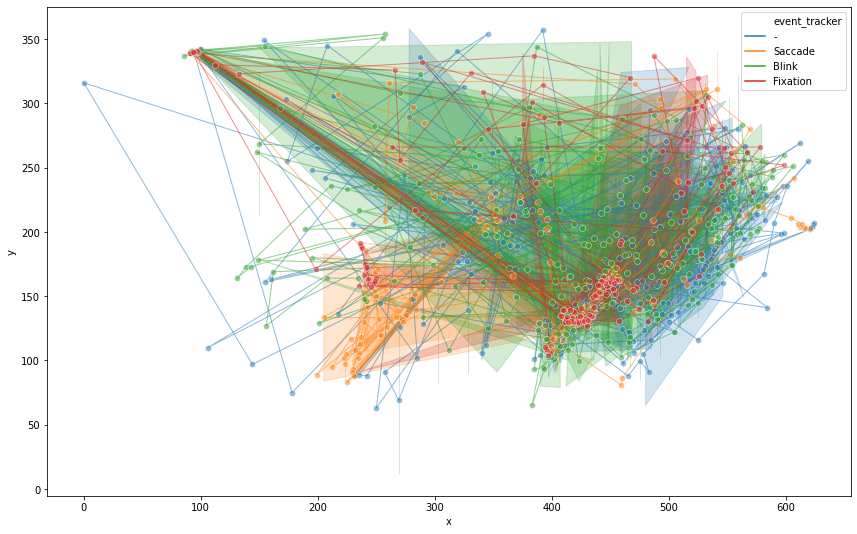

In [138]:
from matplotlib.patches import Rectangle
fix, ax = plt.subplots(figsize=(14.4,9))

#frame = Rectangle((0,b), video_res_x, video_res_y,linewidth=1,facecolor=(0,0,0,0))
#ax.imshow(masked_array)
ax = sns.lineplot(x='x', y='y', hue='event_tracker',  marker="o", alpha=0.5, sort=False, lw=1, data=df)#, legend=False)
#ax.add_patch(frame)



In [ ]:
# Create GIF
import imageio

marked_images = []
path = "/Users/timschroder/Documents/Uni/Bachelorarbeit/Object-Segmentation/Visualisierung/pool/*.jpg"
filenames = [img for img in glob.glob(path)]
filenames.sort()
filenames = filenames[:10] #only first frames
for image in filenames:
    marked_images.append(skimage.io.imread(image))
    
vid = marked_images
imageio.mimsave('/Users/timschroder/Documents/Uni/Bachelorarbeit/Object-Segmentation/Visualisierung/pool/os_label.gif', vid,fps=10)
#HTML('<img src="/Users/timschroder/Documents/Uni/Bachelorarbeit/Object-Segmentation/Visualisierung/pool/os_label.gif">')


In [ ]:
plt.imshow(marked_images[1])

In [ ]:
img_list = masked_images.copy()
gif_save_path = "/Users/timschroder/Documents/Uni/Bachelorarbeit/Color_Segmentation/Code/Visualisierung/fly/OBJ_SEG.gif"

img_list = np.asarray(img_list)
int_images = []
for i in range (0, len(img_list)):
    data = img_list[i]
    #info = np.iinfo(data.dtype) # Get the information of the incoming image type
    data = data.astype(np.float64) / np.amax(data) # normalize the data to 0 - 1
    data = 255 * data # Now scale by 255
    int_img = data.astype(np.uint8)
    int_images.append(int_img)

imageio.mimsave(gif_save_path, int_images,fps=10)

In [319]:
GAZEPATH = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_data/eye_tracking_data_tim/DHF1K_gaze/'
VIDEOPATH = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_data/DHF1K_25/'
EVENTPATH = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_data/eye_tracking_data_tim/events_vid1-50_600-650/'
IMAGEPATH = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_code/graphics/detect_img/001/*.jpg'

translate_dict = {'NOISE':0, 'FIX':1, 'SP':2, 'SACCADE':3}

screen_res_x = 1440; screen_res_y = 900
video_res_x = 640
video_res_y = 360
a=video_res_x/screen_res_x
# size of unused screen in y direction
b=(screen_res_y-video_res_y/a)/2
fps=30
fourcc = cv2.VideoWriter_fourcc(*'DIVX')

videos_run = [1]
subjects_run = [1]#[s+1 for s in range(17)]

markersize = 50
maxframes = 1000

SLIC = False
n_segments = 200
compactness = 10


for v in videos_run:
    
    filenames = [img for img in glob.glob(IMAGEPATH)]
    filenames.sort()
    
    #videoloc = VIDEOPATH + f'{v:03}.AVI'
    #vid = imageio.get_reader(videoloc,  'ffmpeg')
    vidlist = []
    for image in filenames:
        vidlist.append(skimage.io.imread(image))
    
    print(len(vidlist))
    #for image in vid.iter_data():
       # vidlist.append(np.array(image))
    for s in subjects_run:
        nframes = len(vidlist)
        # Add class_ID 
        fps = 30
       
        scanpath = []
        video_name = f'neew_eventVisual_vid{v:03}_sub{s:02}_{maxframes}frames.avi'
        if SLIC:
            video_name = 'slic_'+video_name
        print(video_name)
        # 10 fps, output format due to additional plot, usually (640,360)
        video = cv2.VideoWriter('/Users/timschroder/Documents/Uni/Bachelorarbeit/project_code/graphics/videos_event-class-vis/' + video_name, fourcc, 10, (1200,800))
        # go to either the full video or only through a certain number of frames
        for f in range(min(maxframes,len(vidlist))):
            dtemp = df[(df['time'] > 1e6*f/fps) & (df['time'] < 1e6*(f+1)/fps)] # assign data to frames
            if len(dtemp)>0:
                frame_class = dtemp['class_id'].value_counts().index[0]
            
            fig, axs = plt.subplots(2, gridspec_kw={'height_ratios': [5, 1], 'wspace':0, 'hspace':0.05}, dpi=200)
            fig.suptitle(f'Video {v:03}, Subject {s:02}, Frame {f+1:04}, Class '+ frame_class)
            image = vidlist[f]
            if SLIC:
                label = slic(image, compactness=compactness, n_segments=n_segments, convert2lab = True)
                image = mark_boundaries(image, label) 

            axs[0].imshow(image)
            # filter the df for different events to plot them in different colors
            dfix = dtemp[dtemp['event_class']=='FIX']
            dfix.plot.scatter(x='x', y='y', c='red', ax=axs[0], s=markersize, alpha=.3, marker='o')
            dsp = dtemp[dtemp['event_class']=='SP']
            dsp.plot.scatter(x='x', y='y', c='DarkBlue', ax=axs[0], s=markersize, alpha=.3, marker='o')
            dsac = dtemp[dtemp['event_class']=='SACCADE']
            dsac.plot.scatter(x='x', y='y', c='DarkGreen', ax=axs[0], s=markersize, alpha=.8, marker='x')
            dnoise = dtemp[dtemp['event_class']=='NOISE']
            dnoise.plot.scatter(x='x', y='y', c='white', ax=axs[0], s=markersize, alpha=.8, marker='x')
            axs[0].axis('off')
            # plot where in the event-timeline we currently are
            axs[1].plot(event_num)
            axs[1].set_yticks([0,1,2,3]); axs[1].set_yticklabels(translate_dict.keys())
            axs[1].axvline(250/fps*f, color='red')
            axs[1].set_xticks([], [])
            
            canvas = FigureCanvas(fig)
            canvas.draw()
            width, height = fig.get_size_inches() * fig.get_dpi()
            temp = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)  
            temp = cv2.cvtColor(temp,cv2.COLOR_RGB2BGR)

            video.write(temp)
            plt.close('all'); del temp
        video.release(); del video
        print('done!')




450
neew_eventVisual_vid001_sub01_1000frames.avi


/Users/timschroder/env/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


done!


In [316]:
f=1
fps=30
dtemp = df[(df['time'] > 1e6*f/fps) & (df['time'] < 1e6*(f+1)/fps)] # assign data to frames
frame_class = dtemp['class_id'].value_counts().index[0]


'BG_object_close'

In [366]:
import imageio
import os, sys

class TargetFormat(object):
    GIF = ".gif"
    MP4 = ".mp4"
    AVI = ".avi"

def convertFile(inputpath, targetFormat):
    """Reference: http://imageio.readthedocs.io/en/latest/examples.html#convert-a-movie"""
    outputpath = os.path.splitext(inputpath)[0] + targetFormat
    print("converting\r\n\t{0}\r\nto\r\n\t{1}".format(inputpath, outputpath))

    reader = imageio.get_reader(inputpath)
    fps = reader.get_meta_data()['fps']

    writer = imageio.get_writer(outputpath, fps=fps)
    for i,im in enumerate(reader):
        sys.stdout.write("\rframe {0}".format(i))
        sys.stdout.flush()
        writer.append_data(im)
    print("\r\nFinalizing...")
    writer.close()
    print("Done.")

convertFile("/Users/timschroder/Documents/Uni/Bachelorarbeit/project_code/videos_event-class-vis/eventVisual_vid001_sub03_1000frames.avi", TargetFormat.GIF)

converting
	/Users/timschroder/Documents/Uni/Bachelorarbeit/project_code/videos_event-class-vis/eventVisual_vid001_sub03_1000frames.avi
to
	/Users/timschroder/Documents/Uni/Bachelorarbeit/project_code/videos_event-class-vis/eventVisual_vid001_sub03_1000frames.gif
frame 449
Finalizing...
Done.
